In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 02:57:29 2019

@author: harshwaghela
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  3 18:36:26 2019

@author: harshwaghela
"""

from keras.layers import Input
from keras.models import Model
import os
import numpy as np
import skimage.io
import glob
import keras
from keras.datasets import cifar10
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import preprocessing
import matplotlib.pyplot as plt
from keras.layers.core import Lambda
import tensorflow as tf
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
ck_path = 'CK+48'
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (48, 48, 1)

anger_path = os.path.join(ck_path, 'anger')
disgust_path = os.path.join(ck_path, 'disgust')
fear_path = os.path.join(ck_path, 'fear')
happy_path = os.path.join(ck_path, 'happy')
sadness_path = os.path.join(ck_path, 'sadness')
surprise_path = os.path.join(ck_path, 'surprise')
contempt_path = os.path.join(ck_path, 'contempt')

# # Create lists to store the data and label information
data_x = []   #Store 48x48 images
data_y_e = [] #Store Expression
data_y_f = [] #Store person


directory = glob.glob("CK+48/*")


for folder in directory:
    files = os.listdir(folder)
    files.sort()
    for filename in files:
        if filename=='.DS_Store':
            continue
        I = skimage.io.imread(os.path.join(folder,filename))
        data_x.append(I.tolist())
        label1= folder.split("/")
        label2= filename.split('_')
        data_y_f.append([label2[0]])
        data_y_e.append([label1[1]])


In [3]:
# One hot encoding for labels
mlb = LabelBinarizer()
label1 = mlb.fit_transform(np.array(data_y_f))
label2 = mlb.fit_transform(np.array(data_y_e))

split = train_test_split(data_x, label1,label2, test_size=0.05, random_state=49)
(x_train, x_test, trainfaceY, testfaceY,trainexpY, testexpY) = split
 
 
print(np.shape(x_train))
print(np.shape(x_test))
print(np.shape(trainfaceY))
print(np.shape(testfaceY))
print(np.shape(trainexpY))
print(np.shape(testexpY))

(931, 48, 48)
(50, 48, 48)
(931, 118)
(50, 118)
(931, 7)
(50, 7)


In [4]:
# Normalize data set to 0-to-1 range
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_train /= 255
x_test /= 255

In [6]:
#Reshape sets for the network
x_train = x_train.reshape(x_train.shape[0],48,48,1)
x_test = x_test.reshape(x_test.shape[0],48,48,1)
print(np.shape(x_train))
print(np.shape(x_test))

(931, 48, 48, 1)
(50, 48, 48, 1)


In [20]:
class FaceEmoNet: 
    @staticmethod
    def build_layer(inputs, numfaces,numexp,finalAct="softmax"):
            x=Conv2D(filters=16, kernel_size=(7, 7), padding='same',name='image_array_2', input_shape=(48,48,1))(inputs)
            x=BatchNormalization()(x)
            x=Conv2D(filters=16, kernel_size=(7, 7), padding='same')(x)
            x=BatchNormalization()(x)
            x=Activation('relu')(x)
            x=AveragePooling2D(pool_size=(2, 2), padding='same')(x)
            x=Dropout(.5)(x)
            
            x=Conv2D(filters=32, kernel_size=(5, 5), padding='same')(x)
            x=BatchNormalization()(x)
            x=Conv2D(filters=32, kernel_size=(5, 5), padding='same')(x)
            x=BatchNormalization()(x)
            x=Activation('relu')(x)
            x=AveragePooling2D(pool_size=(2, 2), padding='same')(x)
            x=Dropout(.5)(x)
            
            x=Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
            x=BatchNormalization()(x)
            x=Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
            x=BatchNormalization()(x)
            x=Activation('relu')(x)
            x=AveragePooling2D(pool_size=(2, 2), padding='same')(x)
            x=Dropout(.5)(x)
            x=Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
            x=BatchNormalization()(x)
            x=Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
            x=BatchNormalization()(x)
            x=Activation('relu')(x)
            x=AveragePooling2D(pool_size=(2, 2), padding='same')(x)
            x=Dropout(.5)(x)
            x=Conv2D(filters=256, kernel_size=(3, 3), padding='same')(x)
            x=BatchNormalization()(x)
            y=Conv2D(filters=numfaces, kernel_size=(3, 3), padding='same')(x)
            y=GlobalAveragePooling2D()(y)             
            y=Activation(finalAct,name='face_predict')(y)
            z=Conv2D(filters=numexp, kernel_size=(3, 3), padding='same')(x)
            z=GlobalAveragePooling2D()(z)             
            z=Activation(finalAct,name='exp_predict')(z)
            return [y,z]
    
   
        
    @staticmethod
    def build(width, height, numfaces, numexp, finalAct="softmax"):
        # initialize the input shape
        inputShape = (height, width, 1)
 
        # construct both the "category" and "color" sub-networks
        inputs = Input(shape=inputShape)
        share= FaceEmoNet.build_layer(inputs,numfaces,numexp,finalAct=finalAct)

 
        # create the model using our input (the batch of images) and
        # two separate outputs -- one for the clothing category
        # branch and another for the color branch, respectively
        model = Model(
            inputs=inputs,
            outputs=share,
            name="tester")
 
        # return the constructed network architecture
        return model

In [22]:
#  Define two loss functions and build/compile the model

model = FaceEmoNet.build(48, 48,
    numfaces=len(label1[0]),
    numexp=len(label2[0]),
    finalAct="softmax")

print(model.summary())
losses = {
    "face_predict": "categorical_crossentropy",
    "exp_predict": "categorical_crossentropy",
}

lossWeights = {"face_predict": 1.0, "exp_predict": 1.0}
 
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
    metrics=["accuracy"])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
image_array_2 (Conv2D)          (None, 48, 48, 16)   800         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 48, 48, 16)   64          image_array_2[0][0]              
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 48, 48, 16)   12560       batch_normalization_10[0][0]     
__________________________________________________________________________________________________
batch_norm

In [14]:
H= model.fit(x_train,
    {"face_predict": trainfaceY, "exp_predict": trainexpY},
    validation_data=(x_test,
        {"face_predict": testfaceY, "exp_predict": testexpY}),
    epochs=EPOCHS,
    verbose=1,shuffle=True)

Train on 931 samples, validate on 50 samples
Epoch 1/10
931/931 [==============================] - 13s 14ms/step - loss: 6.3011 - face_predict_loss: 4.4717 - exp_predict_loss: 1.8294 - face_predict_acc: 0.0344 - exp_predict_acc: 0.2997 - val_loss: 10.3218 - val_face_predict_loss: 7.2568 - val_exp_predict_loss: 3.0649 - val_face_predict_acc: 0.0200 - val_exp_predict_acc: 0.4200
Epoch 2/10
931/931 [==============================] - 12s 13ms/step - loss: 4.9275 - face_predict_loss: 3.6483 - exp_predict_loss: 1.2793 - face_predict_acc: 0.1171 - exp_predict_acc: 0.5542 - val_loss: 17.8156 - val_face_predict_loss: 14.0391 - val_exp_predict_loss: 3.7765 - val_face_predict_acc: 0.0600 - val_exp_predict_acc: 0.4400
Epoch 3/10
931/931 [==============================] - 12s 13ms/step - loss: 3.9593 - face_predict_loss: 2.8448 - exp_predict_loss: 1.1145 - face_predict_acc: 0.2632 - exp_predict_acc: 0.5918 - val_loss: 19.6659 - val_face_predict_loss: 13.9865 - val_exp_predict_loss: 5.6793 - val_fac

In [15]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


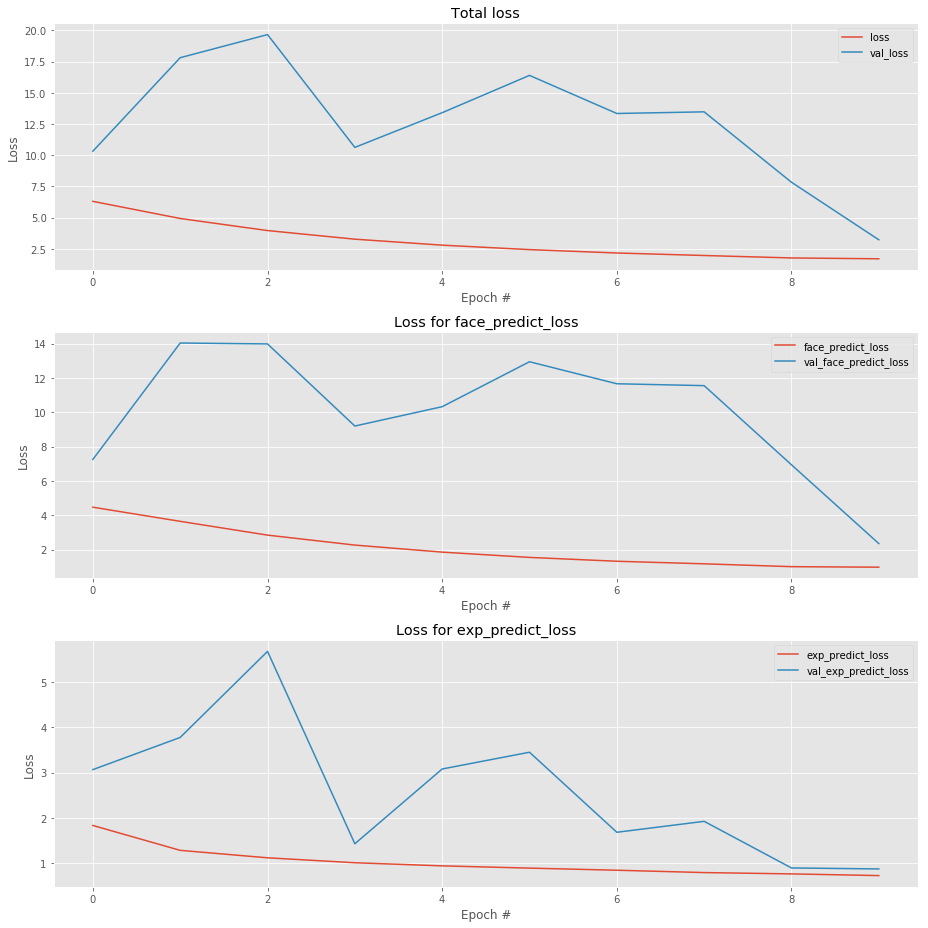

In [16]:
lossNames = ["loss", "face_predict_loss", "exp_predict_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],
        label="val_" + l)
    ax[i].legend()
plt.tight_layout()

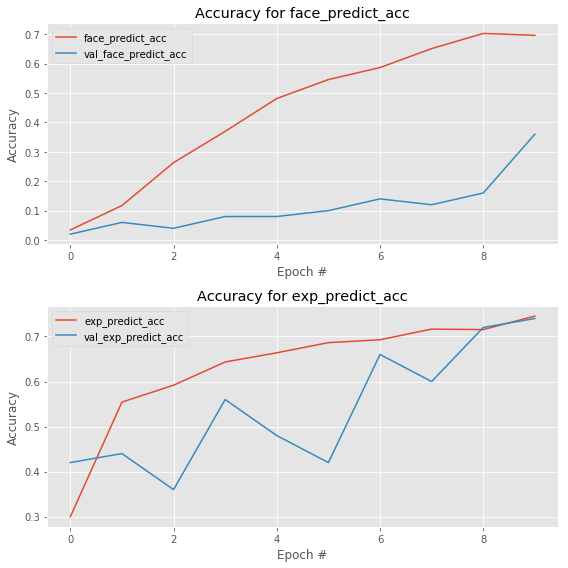

In [19]:
accuracyNames = ["face_predict_acc", "exp_predict_acc"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
 
 
# loop over the accuracy names
for (i, l) in enumerate(accuracyNames):
    # plot the loss for both the training and validation data
    ax[i].set_title("Accuracy for {}".format(l))
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Accuracy")
    ax[i].plot(np.arange(0, EPOCHS), H.history[l], label=l)
    ax[i].plot(np.arange(0, EPOCHS), H.history["val_" + l],label="val_" + l)
    ax[i].legend()
plt.tight_layout()